In [28]:
import pandas as pd 

data = pd.read_csv('data.csv')

data.loc[data['malade'] == False, 'nom_maladie'] = 'healthy'

data.head()

,img_path,espece,malade,nom_maladie
0,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,True,Apple_scab
1,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,True,Apple_scab
2,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,True,Apple_scab
3,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,True,Apple_scab
4,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,True,Apple_scab


### Création d'un échantillon 

In [29]:
class_counts = data['nom_maladie'].value_counts()
species_counts = data['espece'].value_counts()
sick_counts = data['malade'].value_counts()

# Calcul du nombre d'images à prélever
num_images_per_class = round(1500 / len(class_counts))
num_images_per_species = round(1500 / len(species_counts))
num_images_sick = round(2000 / len(sick_counts))

# Création des échantillons équilibrés
sample = pd.DataFrame()
for class_name, count in class_counts.items():
    samples = data[data['nom_maladie'] == class_name].sample(min(count, num_images_per_class), random_state=42)
    sample = sample.append(samples)

for species_name, count in species_counts.items():
    samples = data[data['espece'] == species_name].sample(min(count, num_images_per_species), random_state=42)
    sample = sample.append(samples)

for sick_value, count in sick_counts.items():
    samples = data[data['malade'] == sick_value].sample(min(count, num_images_sick), random_state=42)
    sample = sample.append(samples)

# Mélange aléatoire
sample = sample.sample(frac=1, random_state=42).reset_index(drop=True)

C:\Users\aissa\AppData\Local\Temp\ipykernel_44796\3821067970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(samples)
C:\Users\aissa\AppData\Local\Temp\ipykernel_44796\3821067970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(samples)
C:\Users\aissa\AppData\Local\Temp\ipykernel_44796\3821067970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(samples)
C:\Users\aissa\AppData\Local\Temp\ipykernel_44796\3821067970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(samples)
C:\Users\aissa\AppData\Local\Temp\ipykernel_44796\3821067970

In [30]:
sample

,img_path,espece,malade,nom_maladie
0,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Grape,True,Esca_(Black_Measles)
1,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Tomato,True,Early_blight
2,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,True,Apple_scab
3,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Strawberry,True,Leaf_scorch
4,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Soybean,False,healthy
...,...,...,...,...
4984,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,False,healthy
4985,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,True,Apple_scab
4986,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Potato,True,Late_blight
4987,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Tomato,True,Tomato_Yellow_Leaf_Curl_Virus


In [31]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

In [32]:
# Paramètres du modèle

input_shape = (256, 256, 3)  
num_classes = len(sample.nom_maladie.unique())

### Prétraitement des données

In [33]:
# Normalisation des pixels

data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [34]:
train_generator = data_generator.flow_from_dataframe(
    dataframe=sample,
    x_col="img_path",
    y_col="nom_maladie",
    target_size=input_shape[:2],
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

Found 3992 validated image filenames belonging to 21 classes.


In [35]:
validation_generator = data_generator.flow_from_dataframe(
    dataframe=sample,
    x_col="img_path",
    y_col="nom_maladie",
    target_size=input_shape[:2],
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

Found 997 validated image filenames belonging to 21 classes.


### Modélisation sur l'échantillon

In [36]:
# CNN

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [37]:
# Compilation du modèle

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
# Entraînement du modèle

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=8,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/8
62/62 [==============================] - 176s 3s/step - loss: 3.2255 - accuracy: 0.3404 - val_loss: 2.2948 - val_accuracy: 0.4719
Epoch 2/8
62/62 [==============================] - 174s 3s/step - loss: 1.9533 - accuracy: 0.5224 - val_loss: 1.7246 - val_accuracy: 0.5823
Epoch 3/8
62/62 [==============================] - 176s 3s/step - loss: 1.4459 - accuracy: 0.6487 - val_loss: 1.4924 - val_accuracy: 0.6417
Epoch 4/8
62/62 [==============================] - 181s 3s/step - loss: 1.2196 - accuracy: 0.7177 - val_loss: 1.6230 - val_accuracy: 0.5958
Epoch 5/8
62/62 [==============================] - 179s 3s/step - loss: 1.0361 - accuracy: 0.7816 - val_loss: 1.3427 - val_accuracy: 0.6917
Epoch 6/8
62/62 [==============================] - 170s 3s/step - loss: 0.8530 - accuracy: 0.8414 - val_loss: 1.5088 - val_accuracy: 0.6740
Epoch 7/8
62/62 [==============================] - 169s 3s/step - loss: 0.7371 - accuracy: 0.8770 - val_loss: 1.4618 - val_accuracy: 0.7104
Epoch 8/8
62/62 [===

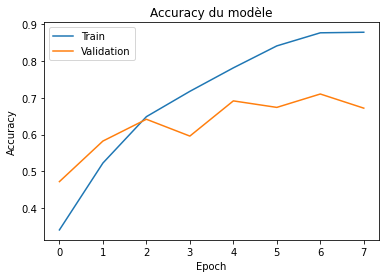

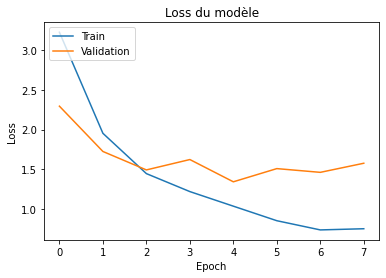

In [39]:
import matplotlib.pyplot as plt

# Visualisation de l'accuracy du train et de la validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy du modèle')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Visualisation de la loss du train et de la validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss du modèle')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Généralisation à l'ensemble du dataset

In [40]:
pip install --upgrade tensorflow

In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint

import os

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

### Division du jeu de données en 10 dataframes équilibrés

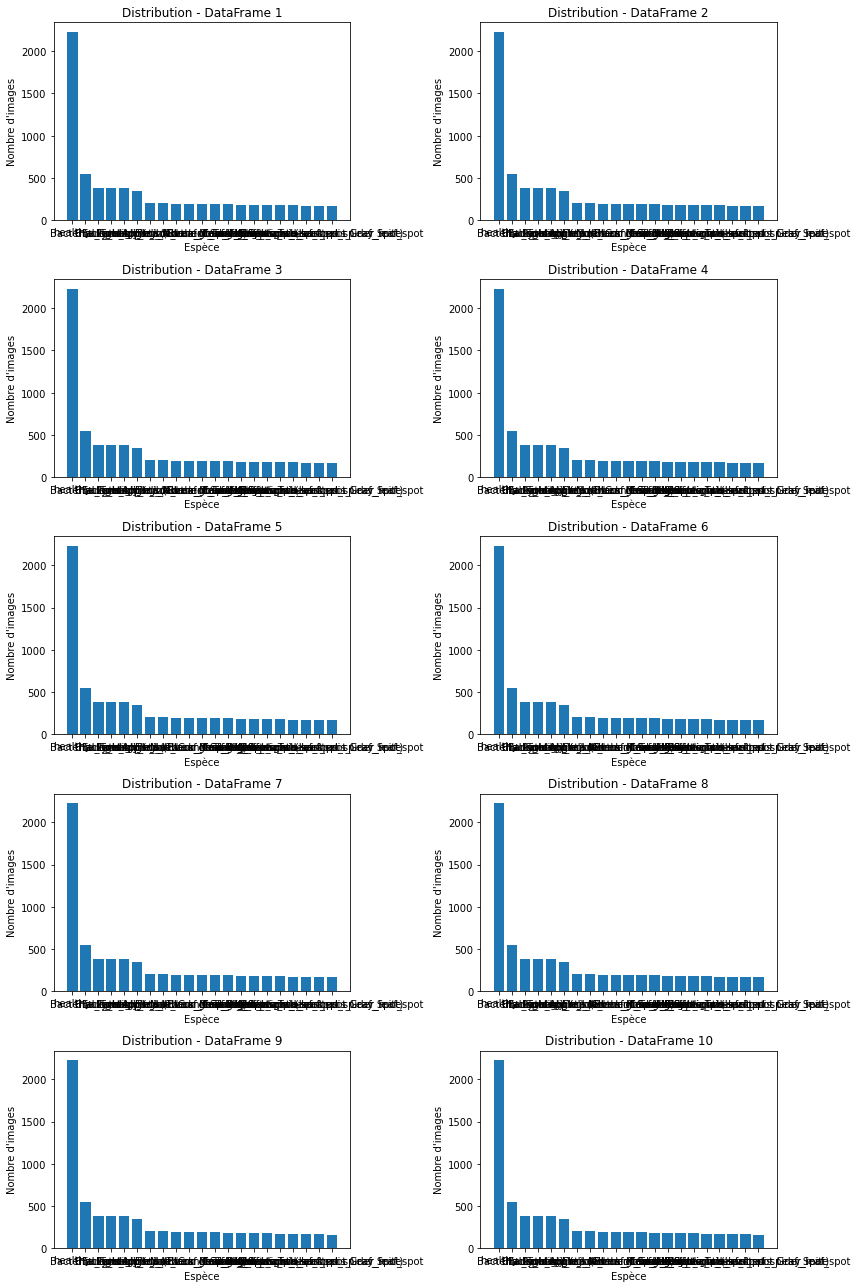

In [42]:
from sklearn.model_selection import StratifiedShuffleSplit

X = data.drop(['espece', 'malade', 'nom_maladie'], axis=1)
y = data['nom_maladie']

dfs = []
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.9)
for train_index, _ in sss.split(X, y):
    df = pd.concat([X.iloc[train_index].reset_index(drop=True), y.iloc[train_index].reset_index(drop=True)], axis=1)
    dfs.append(df)

fig, axs = plt.subplots(5, 2, figsize=(12, 18))

for i, df in enumerate(dfs):
    value_counts = df['nom_maladie'].value_counts()
    
    row = i // 2
    col = i % 2
    
    axs[row, col].bar(value_counts.index, value_counts.values)
    axs[row, col].set_title(f"Distribution - DataFrame {i+1}")
    axs[row, col].set_xlabel("Espèce")
    axs[row, col].set_ylabel("Nombre d'images")

plt.tight_layout()
plt.show()

### Prétraitement des données 

In [43]:
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generators = []
validation_generators = []

for i in range(10):
    data_i = dfs[i]  
    
    train_generator = data_generator.flow_from_dataframe(
        dataframe=data_i,
        x_col="img_path",
        y_col="nom_maladie",
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='categorical',
        subset='training'
    )
    train_generators.append(train_generator)
    
    validation_generator = data_generator.flow_from_dataframe(
        dataframe=data_i,
        x_col="img_path",
        y_col="nom_maladie",
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='categorical',
        subset='validation'
    )
    validation_generators.append(validation_generator)

Found 5624 validated image filenames belonging to 21 classes.
Found 1405 validated image filenames belonging to 21 classes.
Found 5624 validated image filenames belonging to 21 classes.
Found 1405 validated image filenames belonging to 21 classes.
Found 5624 validated image filenames belonging to 21 classes.
Found 1405 validated image filenames belonging to 21 classes.
Found 5624 validated image filenames belonging to 21 classes.
Found 1405 validated image filenames belonging to 21 classes.
Found 5624 validated image filenames belonging to 21 classes.
Found 1405 validated image filenames belonging to 21 classes.
Found 5624 validated image filenames belonging to 21 classes.
Found 1405 validated image filenames belonging to 21 classes.
Found 5624 validated image filenames belonging to 21 classes.
Found 1405 validated image filenames belonging to 21 classes.
Found 5624 validated image filenames belonging to 21 classes.
Found 1405 validated image filenames belonging to 21 classes.
Found 56

### Modélisation 

In [44]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compilation du modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    'cnn_id_nom_maladie.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=True
)

# Boucle pour entraîner le modèle pour chaque data_i

for i in range(10):
    train_generator_i = train_generators[i]
    validation_generator_i = validation_generators[i]

    print(f"Entraînement du modèle pour data_{i+1} :")

    history = model.fit(
        train_generator_i,
        steps_per_epoch=train_generator_i.samples // train_generator_i.batch_size,
        epochs=8,
        validation_data=validation_generator_i,
        validation_steps=validation_generator_i.samples // validation_generator_i.batch_size,
        callbacks=[checkpoint_callback]
    )

    print(f"Fin de l'entraînement du modèle pour data_{i+1}.")
    print()

Entraînement du modèle pour data_1 :
Epoch 1/8
87/87 [==============================] - ETA: 0s - loss: 2.9729 - accuracy: 0.3408
Epoch 1: val_loss improved from inf to 2.27845, saving model to cnn_id_nom_maladie.h5
87/87 [==============================] - 242s 3s/step - loss: 2.9729 - accuracy: 0.3408 - val_loss: 2.2785 - val_accuracy: 0.4368
Epoch 2/8
87/87 [==============================] - ETA: 0s - loss: 1.8787 - accuracy: 0.5371
Epoch 2: val_loss improved from 2.27845 to 1.71437, saving model to cnn_id_nom_maladie.h5
87/87 [==============================] - 238s 3s/step - loss: 1.8787 - accuracy: 0.5371 - val_loss: 1.7144 - val_accuracy: 0.5900
Epoch 3/8
87/87 [==============================] - ETA: 0s - loss: 1.4103 - accuracy: 0.6901
Epoch 3: val_loss improved from 1.71437 to 1.50620, saving model to cnn_id_nom_maladie.h5
87/87 [==============================] - 238s 3s/step - loss: 1.4103 - accuracy: 0.6901 - val_loss: 1.5062 - val_accuracy: 0.6600
Epoch 4/8
87/87 [===========

Epoch 5/8
87/87 [==============================] - ETA: 0s - loss: 0.4285 - accuracy: 0.9736
Epoch 5: val_loss did not improve from 0.94357
87/87 [==============================] - 237s 3s/step - loss: 0.4285 - accuracy: 0.9736 - val_loss: 1.0048 - val_accuracy: 0.8341
Epoch 6/8
87/87 [==============================] - ETA: 0s - loss: 0.4343 - accuracy: 0.9723
Epoch 6: val_loss did not improve from 0.94357
87/87 [==============================] - 236s 3s/step - loss: 0.4343 - accuracy: 0.9723 - val_loss: 0.9770 - val_accuracy: 0.8289
Epoch 7/8
87/87 [==============================] - ETA: 0s - loss: 0.4714 - accuracy: 0.9664
Epoch 7: val_loss did not improve from 0.94357
87/87 [==============================] - 236s 3s/step - loss: 0.4714 - accuracy: 0.9664 - val_loss: 1.0230 - val_accuracy: 0.8118
Epoch 8/8
87/87 [==============================] - ETA: 0s - loss: 0.4490 - accuracy: 0.9730
Epoch 8: val_loss did not improve from 0.94357
87/87 [==============================] - 240s 3s/s

Epoch 1/8
87/87 [==============================] - ETA: 0s - loss: 1.0035 - accuracy: 0.8126
Epoch 1: val_loss did not improve from 0.66738
87/87 [==============================] - 238s 3s/step - loss: 1.0035 - accuracy: 0.8126 - val_loss: 0.8995 - val_accuracy: 0.8534
Epoch 2/8
87/87 [==============================] - ETA: 0s - loss: 0.5666 - accuracy: 0.9550
Epoch 2: val_loss did not improve from 0.66738
87/87 [==============================] - 237s 3s/step - loss: 0.5666 - accuracy: 0.9550 - val_loss: 0.8729 - val_accuracy: 0.8385
Epoch 3/8
87/87 [==============================] - ETA: 0s - loss: 0.4049 - accuracy: 0.9876
Epoch 3: val_loss did not improve from 0.66738
87/87 [==============================] - 237s 3s/step - loss: 0.4049 - accuracy: 0.9876 - val_loss: 0.6842 - val_accuracy: 0.8847
Epoch 4/8
87/87 [==============================] - ETA: 0s - loss: 0.3240 - accuracy: 0.9915
Epoch 4: val_loss improved from 0.66738 to 0.64157, saving model to cnn_id_nom_maladie.h5
87/87 [

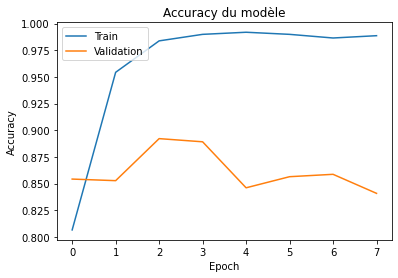

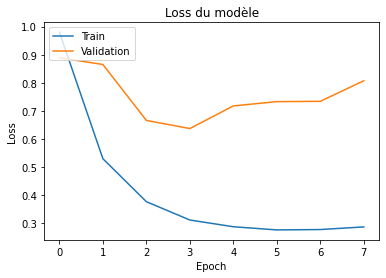

In [45]:
# Visualisation de l'accuracy du train et de la validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy du modèle')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Visualisation de la loss du train et de la validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss du modèle')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Test du modèle sur les données de validation

In [49]:
data_test = pd.read_csv('data_test.csv')

data_test['nom_maladie'] = data_test['nom_maladie'].astype(str)

data_test.head()

,img_path,espece,malade,nom_maladie
0,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,True,Apple_scab
1,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,True,Apple_scab
2,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,True,Apple_scab
3,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,True,Apple_scab
4,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,True,Apple_scab


In [50]:
# Prétraitement des images

image_size = (256, 256)
batch_size = 64

datagen = ImageDataGenerator(rescale=1.0/255.0)

data_generator = datagen.flow_from_dataframe(
    dataframe=data_test,
    x_col='img_path',
    y_col='nom_maladie',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical', 
    shuffle=False  
)


Found 17572 validated image filenames belonging to 21 classes.


In [51]:
# Chargement du modèle 

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.load_weights('cnn_id_nom_maladie.h5')

# Compilation 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Sauvegarde du modèle

model.save('model_cnn_id_nom_maladiee.h5')

In [52]:
# Prédictions

predictions = model.predict(data_generator)

275/275 [==============================] - 133s 477ms/step


In [53]:
import numpy as np

predicted_labels = np.argmax(predictions, axis=1)

In [54]:
true_labels = data_generator.classes
class_labels = data_generator.class_indices

Accuracy : 86.25%


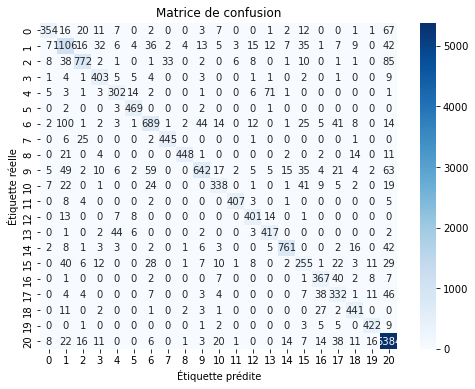

In [55]:
# Évaluation

from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy : {:.2f}%".format(accuracy * 100))

import seaborn as sns

confusion = confusion_matrix(true_labels, predicted_labels)

class_labels = np.unique(true_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Matrice de confusion")
plt.xlabel("Étiquette prédite")
plt.ylabel("Étiquette réelle")
plt.show()